In [132]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [133]:
x_dynamic = pd.read_csv("./processed_data/dynamic_feats.csv")
x_static = pd.read_csv("./processed_data/static_feats.csv")

In [134]:
other_league_cols = ['nba_season_flag',
       'nhl_season_flag', 'nfl_season_flag']

common_features = ["year",
                    "DayofWeek",
                    "HomeTeamGameNumber",
                    "VisitingTeamGameNumber",
                    "park_age",
                    "Month",
                    "DayofMonth",
                    "DayFlag",
                    "NonRegular_ParkFlag",
                    "StadiumCapacity"]+\
                    ["home_payroll", "home_top_salary", "visiting_payroll", "visiting_top_salary"] +\
                    other_league_cols

prev_season_features = ["HomeAttendance_last_year",
                        "VisitingAttendance_last_year",
                        "Attendance_last_year",
                        "Homewin_rate_last_year",
                        "Homeday_league_rank_last_year",
                        "HomeTeamOffense_Homeruns_last_year",
                        "HomeTeamOffense_Strickouts_last_year",
                        "HomeTeamPitchers_TeamEarnedRuns_last_year",
                        "Visitingwin_rate_last_year",
                        "Visitingday_league_rank_last_year",
                        "VisitingTeamOffense_Homeruns_last_year",
                        "VisitingTeamOffense_Strickouts_last_year",
                        "VisitingTeamPitchers_TeamEarnedRuns_last_year",
                        "HomeTeamScore_last_year",
                        "VistingTeamScore_last_year"]

rolling_feats = ['HomeTeamOffense_Homeruns-1',
                'HomeTeamOffense_Homeruns-2',
                'HomeTeamOffense_Homeruns-3',
                'HomeTeamOffense_Homeruns-4',
                'HomeTeamOffense_Homeruns-5',
                'HomeTeamOffense_Homeruns-6',
                'HomeTeamOffense_Homeruns-7',
                'HomeTeamOffense_Strickouts-1',
                'HomeTeamOffense_Strickouts-2',
                'HomeTeamOffense_Strickouts-3',
                'HomeTeamOffense_Strickouts-4',
                'HomeTeamOffense_Strickouts-5',
                'HomeTeamOffense_Strickouts-6',
                'HomeTeamOffense_Strickouts-7',
                'HomeTeamPitchers_TeamEarnedRuns-1',
                'HomeTeamPitchers_TeamEarnedRuns-2',
                'HomeTeamPitchers_TeamEarnedRuns-3',
                'HomeTeamPitchers_TeamEarnedRuns-4',
                'HomeTeamPitchers_TeamEarnedRuns-5',
                'HomeTeamPitchers_TeamEarnedRuns-6',
                'HomeTeamPitchers_TeamEarnedRuns-7']

prev_match_features = [prefix+base_col for prefix in ["Home","Visiting"] 
                       for base_col in ["total_wins",
                                        "day_league_rank"]]

TARGET_COL = "Attendance"

In [135]:
x_static["league_rival_col"] = (x_static["VisitingTeamLeague"]==x_static["HomeTeamLeague"]).astype(int)
x_dynamic["league_rival_col"] = (x_static["VisitingTeamLeague"]==x_static["HomeTeamLeague"]).astype(int)
common_features.append("league_rival_col")

In [136]:
# x_static["weekend"] = x_static["DayofWeek"].isin([4,5]).astype(int)
# x_dynamic["weekend"] = x_static["DayofWeek"].isin([4,5]).astype(int)
# common_features.append("weekend")
# common_features.remove("DayofWeek")

In [137]:
def covid_impact(year):
    covid_effect = 0
    if year >= 2021:
        covid_effect = 1/(year - 2020)
    return covid_effect

x_dynamic["covid_effect"] = x_dynamic["year"].map(covid_impact)
x_static["covid_effect"] = x_dynamic["covid_effect"]
common_features.append("covid_effect")

## Model Training

### Dynamic Model

In [138]:
train_idx = x_dynamic["year"]!=2022
val_idx = x_dynamic["year"]==2022

y_train = x_dynamic.loc[train_idx, TARGET_COL]
y_val = x_dynamic.loc[val_idx, TARGET_COL]

In [139]:
match_cols = ["year","HomeTeam","HomeTeamGameNumber"]
x_dynamic = pd.merge(x_dynamic,
        x_static[prev_season_features+match_cols],
        on=match_cols)

In [140]:
categorical_feat_cols = ["VisitingTeam",
                        "VisitingTeamLeague",
                        "HomeTeam",
                        "HomeTeamLeague",
                        "BallParkID"]

feat_list = categorical_feat_cols+common_features+list(rolling_feats)+prev_match_features+prev_season_features

x_dynamic_train = x_dynamic.loc[train_idx, feat_list]
x_dynamic_val = x_dynamic.loc[val_idx, feat_list]

# model = lgb.LGBMRegressor()
# model.fit(x_dynamic_train, y_train)

In [141]:
import lightgbm as lgb
# from basic_ml.embedding import DFEmbedder

# x_dynamic_train, x_dynamic_val = DFEmbedder.gen_multi_col_embeddings(train=x_dynamic_train,
#                         encode_cols=categorical_feat_cols,
#                         test=x_dynamic_val,
#                         max_output_size=10,
#                         fraction_threshold=0.5)

# x_dynamic_train.drop(columns=categorical_feat_cols, inplace=True)
# x_dynamic_val.drop(columns=categorical_feat_cols, inplace=True)

In [142]:
# from basic_ml import ModelEvaluator, ModelExecutor

# # The search space for the algorithm
# # we run multiple trials to find the best value to use for each hyperparameter
# lgb_param = {'num_leaves': (5, 500, 5),
#             'max_depth': (2, 100, 2),
#             'learning_rate': (0.001, 0.2, 0.001),
#             'n_estimators': (20, 500, 20),
#             'min_child_samples': (5, 100, 5), 
#             'reg_lambda': (0.1, 1, 0.1),
#             'reg_alpha': (0.1, 1, 0.1),
#             "random_state": 42,
#             'metric': "mae"}

# # Tuning and finding the best configured model
# lgb_tuner = ModelExecutor(lgb.LGBMRegressor,
#                           x_dynamic_train,
#                           y_train,
#                           x_val=x_dynamic_val,
#                           y_val=y_val,
#                           internal_val=True,
#                           task="regression",
#                           cv=False,
#                           normalize=False,
#                           param_grid=lgb_param)

# lgb_tuner.execute(max_evals=50)

# y_pred = lgb_tuner.model.predict(x_dynamic_val)
# mean_absolute_error(y_val, y_pred), mean_absolute_percentage_error(y_val, y_pred), mean_squared_error(y_val, y_pred)

In [143]:
model = lgb.LGBMRegressor()
model.fit(x_dynamic_train.drop(columns=categorical_feat_cols), y_train)

y_pred = model.predict(x_dynamic_val.drop(columns=categorical_feat_cols))
mean_absolute_error(y_val, y_pred), mean_absolute_percentage_error(y_val, y_pred), mean_squared_error(y_val, y_pred)

(3080.0857881095067, 0.13877345869673408, 16722280.384388657)

In [148]:
def calculate_error(y_test, y_pred, x_test, w1=0.05):
    april_mask = x_test["Month"]==4
    mn_twins_mask = x_test["HomeTeam"]=="MIN"
    april_error = w1*(np.abs(y_test[(april_mask) & (mn_twins_mask)]-y_pred[(april_mask) & (mn_twins_mask)]).sum())\
                    +(1-w1)*(np.abs(y_test[(april_mask) & ~(mn_twins_mask)]-y_pred[(april_mask) & ~(mn_twins_mask)])).sum()
    season_error = w1*(np.abs(y_test[mn_twins_mask]-y_pred[mn_twins_mask]).sum())\
                        +(1-w1)*(np.abs(y_test[~mn_twins_mask]-y_pred[~mn_twins_mask]).sum())
    return april_error, season_error    

In [149]:
calculate_error(y_val, y_pred, x_dynamic_val)

(1094803.189224404, 6936132.425170523)

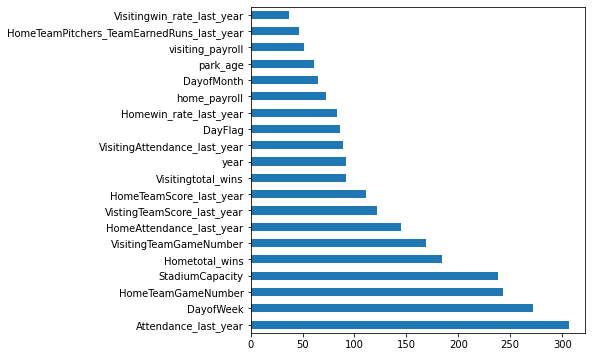

In [116]:
import matplotlib.pyplot as plt
def plot_feat_importance(model, top_n=20):
    plt.figure(figsize=(6,6))
    pd.Series(dict(
        zip(model.feature_name_,
        model.feature_importances_))
        ).sort_values(ascending=False)[:top_n].plot.barh()
    
plot_feat_importance(model)

In [52]:
# BASELINE MODEL 2 -> MEAN
x_dynamic["GamesPlayedAtHome"] = x_dynamic.groupby(
    ["HomeTeam","year"])["Attendance"].cumcount()+1
y_pred = x_dynamic[
    x_dynamic["GamesPlayedAtHome"]<=81
    ].groupby(["HomeTeam","GamesPlayedAtHome"])["Attendance"].mean().values
mean_absolute_error(y_val, y_pred), mean_absolute_percentage_error(y_val, y_pred), mean_squared_error(y_val, y_pred)

(6790.477495073443, 0.4001449791914596, 67745080.98026977)

In [65]:
# BASELINE MODEL 1 -> LOCF
y_pred_baseline = ([45000]+x_static.loc[x_static["year"]==2021,"Attendance"].tolist())#*x_dynamic.loc[val_idx, "StadiumCapacity"]
mean_absolute_error(y_val, y_pred_baseline), mean_absolute_percentage_error(y_val, y_pred_baseline), mean_squared_error(y_val, y_pred_baseline)

(14379.790428657569, 0.640593048743479, 306704071.0503633)

### Static Model

In [54]:
x_static_train = x_static.loc[train_idx, common_features+prev_season_features]

x_static_val = x_static.loc[val_idx, common_features+prev_season_features]

model = lgb.LGBMRegressor()
model.fit(x_static_train, y_train)

LGBMRegressor()

In [55]:
y_pred = model.predict(x_static_val)#*x_static.loc[val_idx, "StadiumCapacity"]
mean_absolute_error(y_val, y_pred), mean_absolute_percentage_error(y_val, y_pred), mean_squared_error(y_val, y_pred)

(9570.122895853143, 0.36309923107638886, 146139163.14398566)